In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser
import time
import pickle

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.layers import Input
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices
import scipy.io as sio
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import nibabel as nib


# project imports
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras

Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [5]:
vol_size = (160, 192, 224)  
def mind(d, patch_size, var=0.004, use_ssc=False, use_gaussian_kernel=False):
    # see http://www.mpheinrich.de/pub/MEDIA_mycopy.pdf
    if use_gaussian_kernel:
        dist = tf.distributions.Normal(0., 1.)

        vals = dist.prob(tf.range(start = -(patch_size-1)/2, limit = (patch_size-1)/2 + 1, dtype = tf.float32))
        kernel = tf.einsum('i,j,k->ijk', vals, vals, vals)
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = kernel[:,:,:,tf.newaxis, tf.newaxis]
    else:
        kernel = tf.ones([patch_size, patch_size, patch_size, 1, 1])/(patch_size**3)
        
    def ssd_shift(image, direction):
        # expects a 3d image
        x,y,z = vol_size
        new_shift = np.clip(direction, 0, None)
        old_shift = -np.clip(direction, None, 0)

        # translate images
        new_image = image[new_shift[0]:x-old_shift[0], new_shift[1]:y-old_shift[1], new_shift[2]:z-old_shift[2]]
        old_image = image[old_shift[0]:x-new_shift[0], old_shift[1]:y-new_shift[1], old_shift[2]:z-new_shift[2]]
        # get squared difference
        diff = tf.square(new_image - old_image)

        # pad the diff
        padding = np.transpose([old_shift, new_shift])
        diff = tf.pad(diff, padding)

        # apply convolution
        conv = tf.nn.conv3d(diff[tf.newaxis,:,:,:,tf.newaxis], kernel, [1]*5, 'SAME')
        return tf.exp(-conv/var)

    def mind_loss(y_true, y_pred):
        ndims = 3
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        loss_tensor = 0
        for i in range(ndims):
            direction = [0]*3
            direction[i] = d

            loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, direction) - ssd_shift(y_pred, direction)))

            direction = [0]*3
            direction[i] = -d
            loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, direction) - ssd_shift(y_pred, direction)))

        return loss_tensor/(ndims*2)

    def ssc_loss(y_true, y_pred):
        ndims = 3
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        loss_tensor = 0
        directions = []
        for i in range(ndims):
            direction = [0]*3
            direction[i] = d
            directions.append(direction)

            direction = [0]*3
            direction[i] = -d
            directions.append(direction)

        for i in range(len(directions)):
            for j in range(i, len(directions)):
                d1 = directions[i]
                d2 = directions[j]

                loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, d1) - ssd_shift(y_pred, d2)))

        return loss_tensor/(len(directions)*(len(directions)-1)/2)

    if use_ssc:
        return ssc_loss
    else:
        return mind_loss

In [16]:
def create_graph(model_name, iter_num, step_size, gpu_id, n_test, use_train_images=False, indexing='ij', invert_images=False, loss_function=None, max_clip=0.7):    
    if use_train_images:
        test_brain_file = open('../src/train_files.txt')
    else:
        test_brain_file = open('../src/val_files.txt')
    test_brain_strings = test_brain_file.readlines()
    test_brain_strings = [x.strip() for x in test_brain_strings]
    n_batches = len(test_brain_strings)
    good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
    
    # setup
    gpu = '/gpu:' + str(gpu_id)
    #     print(gpu)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

    restrict_GPU_tf(str(gpu_id))
    restrict_GPU_keras(str(gpu_id))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    vol_size=(160,192,224)
    nf_enc=[16,32,32,32]
    nf_dec=[32,32,32,32,32,16,16]
    
    atlas_vol = nib.load('../data/t2_atlas_027_S_2219.nii').get_data()[np.newaxis,...,np.newaxis]
    atlas_seg = nib.load('../data/t2_atlas_seg_027_S_2219.nii').get_data()
    
    atlas_vol = atlas_vol/np.max(atlas_vol) * max_clip

    images = []
    for step in range(0, n_test):
        vol_name, seg_name = test_brain_strings[step].split(",")
        X_vol, X_seg = datagenerators.load_example_by_name(vol_name, seg_name)
        images.append([X_vol, X_seg])

    sz = atlas_seg.shape
    z_inp1 = tf.placeholder(tf.float32, sz)
    z_inp2 = tf.placeholder(tf.float32, sz)
    z_out = losses.kdice(z_inp1, z_inp2, good_labels)
    kdice_fn = K.function([z_inp1, z_inp2], [z_out])

    trf_model = networks.trf_core(vol_size, nb_feats=len(good_labels)+1, indexing=indexing)
    
    dices = []
    loss_arr = []
    
    if loss_function != None:
        y_true = Input((1, *vol_size, 1) , name='y_true')
        y_pred = Input((1, *vol_size, 1) , name='y_pred')
        output = loss_function(y_true, y_pred)
        loss_K_function = K.function([y_true, y_pred], [output])
    
    for i in range(iter_num//step_size + 1):
        print(i)
        start_time = time.time()
        iter_str = str(i*step_size)
        if i*step_size < 10:
            iter_str = '0' + iter_str
        # load weights of model
        with tf.device(gpu):
            net = networks.cvpr2018_net(vol_size, nf_enc, nf_dec)
            net.load_weights('../models/' + model_name +
                             '/' + iter_str + '.h5')

        print('model loaded', time.time()-start_time)
        dice_means = []
        loss_means = []

        with tf.device(gpu):
            sess = tf.Session(config=config)
            for step in range(0, n_test):
                X_vol, X_seg = images[step]
                if invert_images:
                    X_vol = max_clip - X_vol

                pred = net.predict([X_vol, atlas_vol])
                seg = np.copy(X_seg)
                all_labels = np.unique(seg)
                for l in all_labels:
                    if l not in good_labels:
                        seg[seg==l] = 0
                for j in range(len(good_labels)):
                    seg[seg==good_labels[j]] = j+1
                seg_onehot = tf.keras.utils.to_categorical(seg[0,:,:,:,0], num_classes=len(good_labels)+1)
                warp_seg_onehot = trf_model.predict([seg_onehot[tf.newaxis,:,:,:,:], pred[1]])
                warp_seg = np.argmax(warp_seg_onehot[0,:,:,:,:], axis=3)

                warp_seg_correct = np.zeros(warp_seg.shape)
                for j in range(len(good_labels)):
                    warp_seg_correct[warp_seg==j+1] = good_labels[j]

                dice = kdice_fn([warp_seg_correct, atlas_seg])
                dice_means.append(np.mean(dice))
                print(np.mean(dice))
                
#                 with sess.as_default():
                if loss_function != None:
                    loss_val = loss_K_function([atlas_vol, pred[0]])[0]
                    print(loss_val)
                    loss_means.append(loss_val)
                    
        print('tested patients', time.time()-start_time)
        dices.append(np.mean(dice_means))
        print('dice at step', i*step_size, dices[-1])
        if loss_function != None:
            loss_arr.append(np.mean(loss_means))
    return dices, loss_arr


In [17]:
model_name = 'mind_d2p3l05_v'
num_iters = 1500
step_size = 100
gpu_id = 3
n_test = 10
use_train_images = False

# d = 2
# patch_size = 3
# use_ssc = True
# use_gaussian_kernel = False

# loss_function = mind(d, patch_size, var=0.004, use_ssc=use_ssc, use_gaussian_kernel=use_gaussian_kernel)
loss_function = None
dices, loss_arr = create_graph(model_name, num_iters, step_size, gpu_id, n_test, use_train_images=use_train_images, loss_function=loss_function)

Using GPU:3 with 0% of the memory
Using GPU:3 with 0% of the memory
0
model loaded 1.2102882862091064
0.45723894
0.55512595
0.5527343
0.40344077
0.49777964
0.49119884
0.52479094
0.44223303
0.46297842
0.4647683
tested patients 61.73283648490906
dice at step 0 0.48522893
1
model loaded 1.3742444515228271
0.62167484
0.6771294
0.6965736
0.57427704
0.6735726
0.6617155
0.6415911
0.58629
0.628002
0.5982395
tested patients 59.5750949382782
dice at step 100 0.6359066
2
model loaded 1.518035888671875
0.6289513
0.6911783
0.70744026
0.58907
0.68295205
0.6729591
0.64774716
0.5945103
0.63412315
0.6143371
tested patients 58.599419355392456
dice at step 200 0.6463269
3
model loaded 2.551549196243286
0.63132805
0.68764144
0.6990966
0.59317887
0.69429386
0.6852115
0.6336313
0.5936966
0.6356998
0.6101864
tested patients 59.653913497924805
dice at step 300 0.64639646
4
model loaded 1.8136250972747803
0.6401236
0.69159704
0.7053892
0.5951073
0.69624907
0.6843526
0.64453596
0.60369676
0.6400309
0.61687005
t

In [12]:
file = open('../models/%s/%s.txt' % (model_name, model_name),'wb') 
pickle.dump([num_iters, step_size, dices], file)
file.close()

mind_d2p3l05_v


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(0.65, 0.67)

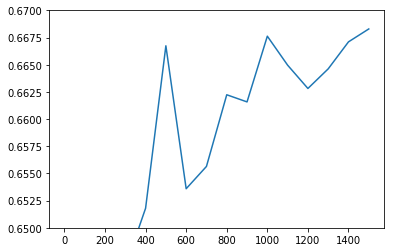

In [18]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


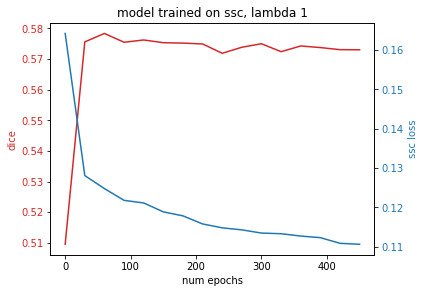

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('num epochs')
ax1.set_ylabel('dice', color=color)
ax1.plot(np.linspace(0, num_iters, num_iters/step_size+1), dices, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ssc loss', color=color)  # we already handled the x-label with ax1
ax2.plot(np.linspace(0, num_iters, num_iters/step_size+1), loss_arr, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('model trained on ssc, lambda 1')
plt.show()

mind_d2p3l05


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


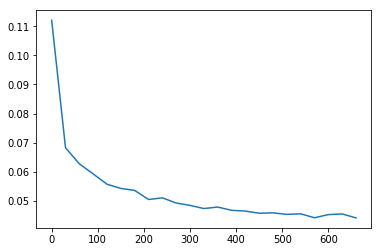

In [15]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), loss_arr)
# plt.ylim(0.65, 0.67)

mi_t2g_b32l5s05


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


(0.65, 0.67)

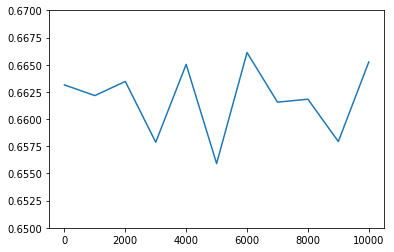

In [11]:
print(model_name)
plt.plot(np.linspace(0, num_iters, num_iters/step_size+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0,0.5,'MI')

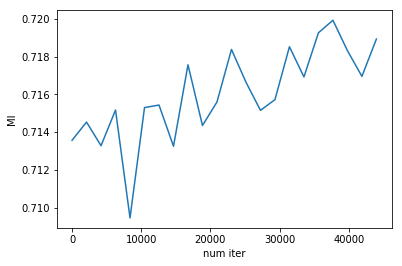

In [9]:
file = open('../models/mi_b45l5/mi_b45l5.txt','rb') 
dices, mis = pickle.load(file)
plt.plot(np.linspace(0, 44000, 44000/2000), mis)
plt.xlabel('num iter')
plt.ylabel('MI')

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


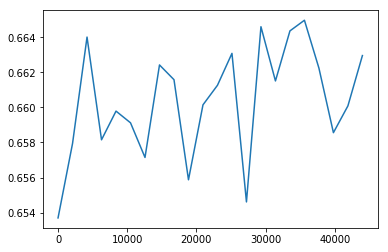

In [8]:
plt.plot(np.linspace(0, 44000, 44000/2000), dices)


/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


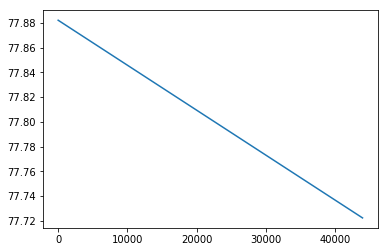

In [9]:
plt.plot(np.linspace(0, 44000, 44000/40000+1), mis)
# plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.65, 0.67)

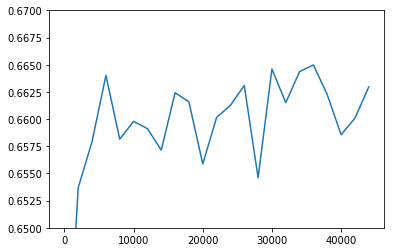

In [8]:
plt.plot(np.linspace(0, 44000, 44000/2000+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.65, 0.67)

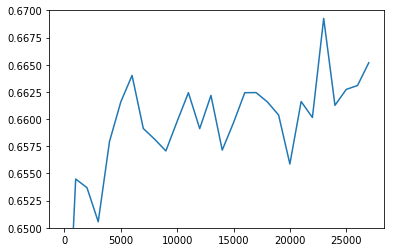

In [20]:
plt.plot(np.linspace(0, 27000, 27000/1000+1), dices)
plt.ylim(0.65, 0.67)

/afs/csail.mit.edu/u/c/courtney/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


(0.72, 0.75)

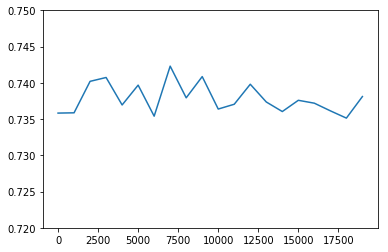

In [7]:
plt.plot(np.linspace(0, 19000, 19000/1000+1), dices)
plt.ylim(0.72, 0.75)

(0.68, 0.72)

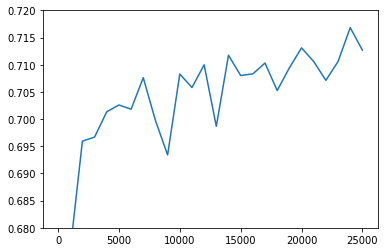

In [20]:
plt.plot(np.linspace(0, 25000, 26), dices)
plt.ylim(0.68, 0.72)

(0.68, 0.7)

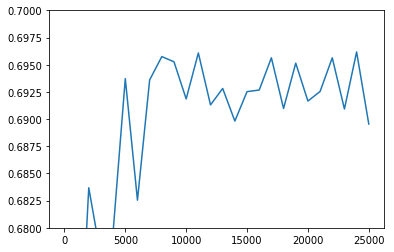

In [19]:
plt.plot(np.linspace(0, 25000, 26), dices)
plt.ylim(0.68, 0.7)

In [21]:
%%time
dices = []
step_size = 5000
for i in range(25000//step_size + 1):
    print(i)
    dices.append(test(model_name, i*step_size, gpu_id, 10, True, 0.7))

0
1
2
3
4
5
CPU times: user 8min 49s, sys: 1min 10s, total: 10min
Wall time: 6min 28s


In [28]:
%%time
dices_2 = []
step_size = 5000
for i in range(iter_num//step_size + 1):
    print(i)
    dices_2.append(test(model_name, i*step_size, gpu_id, 10, False, 0.7))

0
1
2
3
4
5
6
7
8
CPU times: user 13min 28s, sys: 2min 13s, total: 15min 41s
Wall time: 10min 17s


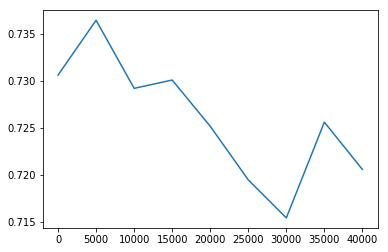

In [30]:
plt.plot([i*step_size for i in range(iter_num//step_size + 1)], dices_2)

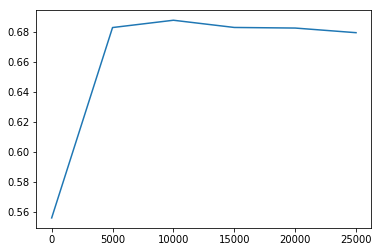

In [31]:
plt.plot([i*step_size for i in range(25000//step_size + 1)], dices)